In [369]:
import numpy as np  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random
import math as m
import pandas as pd

In [370]:
NUM_ITERATIONS = 10
NUM_WOLFS = 10
NUM_INTERVALS = 96

In [371]:
def insert_travels_in_cars_state(cars_state, travels):
    cars_state_copy = cars_state.copy()
    cars_state_copy = list(cars_state_copy)
    for i, car_travels in enumerate(travels):
        for travel in car_travels:
            start, end = travel
            position = start + 96 * i
            cars_state_copy[position:position] = [0] * (end - start + 1)

    return cars_state_copy

In [372]:
def split_list(lst, chunk_size=NUM_INTERVALS):
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [373]:
def calculate_car_power(car_states, car):
    car_power = []
    for state in car_states:
        if state == 1:
            car_power.append(car["tx_charge"])
        elif state == -1:
            car_power.append(-car["tx_discharge"])
        else:
            car_power.append(0)

    return car_power

In [374]:
def cost_function(sample, travels, cars, generated_power, products_demand, energy_cost):
    cars_state_with_travels = insert_travels_in_cars_state(sample, travels)
    separated_cars_state = split_list(cars_state_with_travels)
    cars_power = [
        calculate_car_power(car_states, car)
        for car_states, car in zip(separated_cars_state, cars)
    ]
    total_cars_power = np.sum(cars_power, axis=0)
    total_liquid_power = generated_power - products_demand - total_cars_power
    money_in_time = total_liquid_power * energy_cost
    total_money_cost = np.sum(money_in_time)

    return -total_money_cost.tolist()

In [375]:
def generate_min_charging_random_vector(total_size, min_charging, car):
    vector = []
    car_battery = 0
    is_charged = False

    for i in range(total_size):
        if i == 0:
            choice = 1
        elif car_battery - car["tx_discharge"] >= 0 and not is_charged:
            choice = random.choice([-1, 1])
        elif car_battery - car["tx_discharge"] >= 0:
            choice = -1
        elif not is_charged:
            choice = 1

        vector_aux = vector.copy()
        vector_aux.append(choice)
        vector_aux.append((total_size - i - 1) * [1])
        chargings = vector_aux.count(1)
        dischargings = vector_aux.count(-1)

        if (
            chargings * car["tx_charge"] - dischargings * car["tx_discharge"]
            < min_charging * car["tx_charge"]
        ):
            choice = 1

        if choice == -1:
            car_battery -= car["tx_discharge"]
            is_charged = False
        else:
            car_battery += car["tx_charge"]

        if car_battery >= car["autonomy_kwh"]:
            car_battery = car["autonomy_kwh"]
            is_charged = True

        vector.append(choice)

    return vector

In [376]:
def generate_cars_state(charge_times, available_intervals, cars):
    return [
        element
        for available_list in [
            generate_min_charging_random_vector(end - start + 1, min_charge, car)
            for charge_time, car_available_intervals, car in zip(
                charge_times, available_intervals, cars
            )
            for (start, end), min_charge in zip(car_available_intervals, charge_time)
        ]
        for element in available_list
    ]

In [377]:
def find_available_intervals(occupied_positions):
    available_intervals = []
    current_start = 0

    for start, end in sorted(occupied_positions):
        if current_start < start:
            available_intervals.append((current_start, start - 1))
        current_start = end + 1

    if current_start < NUM_INTERVALS:
        available_intervals.append((current_start, NUM_INTERVALS - 1))

    return available_intervals

In [378]:
def calculate_travel_charge_time(travel, tx_charge, tx_discharge):
    start, end = travel
    spent_energy = (end - start + 1) * tx_discharge
    charge_time = m.ceil(spent_energy / tx_charge)

    return charge_time

In [379]:
def calculate_charge_times(available_intervals, travels, cars):
    return [
        [
            calculate_travel_charge_time(travel, car["tx_charge"], car["tx_discharge"])
            for travel in car_travels
        ]
        + [0] * (len(available_interval) - len(car_travels))
        for car, car_travels, available_interval in zip(
            cars.copy(), travels.copy(), available_intervals.copy()
        )
    ]

In [380]:
def PotGD():
    """
    Calcula a potência gerada pela GD (gerador distribuído) em um quarto de dia (24 horas).

    Retorna:
        potenciaGeradaQuarter: vetor com a potência gerada a cada 15 minutos (num_intervals valores).
    """

    # Leitura de dados meteorológicos
    dados_met = pd.read_csv("./DadosMeterologicos2024.csv", delimiter=";", header=0)

    # Conversão da tabela em matriz
    dados_met = dados_met.to_numpy()

    # Parâmetros do aerogerador VERNE 555
    vel_corte_entrada = 2.2
    vel_corte_saida = 16

    # Velocidades e potências do aerogerador
    velocidades = [2.2, 6, 7.1, 8.2, 9, 9.7, 10.5, 10.8, 13.8, 16]
    potencias = [0, 1, 2, 3, 4, 5, 6, 6.5, 7, 6.7]

    # Coeficientes da polinômia de ajuste
    coeficientes = np.polyfit(velocidades, potencias, 5)

    # Número de linhas da tabela de dados meteorológicos
    num_linhas = dados_met.shape[0]

    # Cálculo da potência do aerogerador por hora
    potencia_aero = np.zeros(num_linhas)
    for i in range(num_linhas):

        if dados_met[i, 2] >= vel_corte_entrada and dados_met[i, 2] <= vel_corte_saida:
            # Cálculo da potência usando a polinômia de ajuste
            potencia_aero[i] = (
                coeficientes[0] * dados_met[i, 2] ** 5
                + coeficientes[1] * dados_met[i, 2] ** 4
                + coeficientes[2] * dados_met[i, 2] ** 3
                + coeficientes[3] * dados_met[i, 2] ** 2
                + coeficientes[4] * dados_met[i, 2]
                + coeficientes[5]
            )
        elif dados_met[i, 2] > vel_corte_saida:
            # Potência máxima do aerogerador
            potencia_aero[i] = 6.7
        else:
            # Potência zero
            potencia_aero[i] = 0

        # Correção para valores negativos (erro de arredondamento)
        if potencia_aero[i] < 0:
            potencia_aero[i] = 0

    # Conversão para kW
    potencia_aero *= 1000

    # Cálculo da potência gerada pelos painéis fotovoltaicos (modelo 4 CS3Y 500ms)
    num_paineis = 1  # Número de painéis
    temp_nominal = 42  # Temperatura nominal de operação da célula (oC)
    isc = 11.77  # Corrente de curto circuito da célula (A)
    ki = 0.05  # Coeficiente de corrente/temperatura (A/oC)
    voc = 53.7  # Tensão de circuito aberto do módulo (V)
    kv = 0.26  # Coeficiente de tensão/temperatura (V/oC)
    vmppt = 45  # Tensão no ponto de máxima potência (V)
    imppt = 11.12  # Corrente no ponto de máxima potência (A)

    potencia_pv = np.zeros(num_linhas)

    for i in range(num_linhas):
        ta = dados_met[i, 1]
        r = dados_met[i, 0] / 3600
        tc = ta + r * (temp_nominal - 20) / 0.8
        i_pv = r * (isc + ki * (tc - 25))
        v_pv = voc - kv * (tc - 25)
        ff = (vmppt * imppt) / (voc * isc)
        potencia_pv[i] = num_paineis * ff * v_pv * i_pv

    # Combinação das potências
    pot = (2 * potencia_aero + 40 * potencia_pv) / 1000

    # Interpolação e ajuste dos valores
    potenciaGeradaQuarter = preencher_vetores_interpolacao(pot, NUM_INTERVALS) * 0.25

    for i in range(1, len(potenciaGeradaQuarter) - 1):
        if (
            potenciaGeradaQuarter[i - 1] > 0
            and potenciaGeradaQuarter[i + 1] > 0
            and potenciaGeradaQuarter[i] == 0
        ):
            potenciaGeradaQuarter[i] = (
                potenciaGeradaQuarter[i - 1] + potenciaGeradaQuarter[i + 1]
            ) / 2

    return potenciaGeradaQuarter

In [381]:
def preencher_vetores_interpolacao(your_existing_data, size_wanted):
    # Your existing data with 1000 values
    existing_data = your_existing_data  # Replace with your data

    # Desired number of positions
    desired_length = size_wanted

    # Create a new array to hold the interpolated data
    interpolated_data = np.zeros(desired_length)

    # Calculate the number of intervals between existing data points
    num_intervals = len(existing_data) - 1

    # Calculate the step size to insert between existing data points
    step_size = 1 / (num_intervals + 1)

    # Loop through the existing data points and interpolate values
    for i in range(num_intervals):
        start_index = int((i * desired_length) / num_intervals)
        end_index = int(((i + 1) * desired_length) / num_intervals)

        # Linear interpolation between existing_data[i] and existing_data[i+1]
        interpolated_data[start_index:end_index] = np.linspace(
            existing_data[i], existing_data[i + 1], end_index - start_index
        )

    # Fill the remaining positions with the last value in existing_data
    interpolated_data[end_index + 1 :] = existing_data[-1]

    return interpolated_data

In [382]:
def calculate_products_demand():
    # horario que os produtos ficam prontos
    num_elementos = 30

    # Produção de entrega 4 até as 22
    horaProducao = 4 + (18 * np.random.rand(num_elementos, 1))

    # Inicializando a curva de demanda total dos produtos fabricados
    horaFinalProducao = horaProducao
    horaInicialProducao = horaProducao - 2

    # Número de intervalos de tempo em um dia (24 horas discretizadas em 15 minutos)
    numIntervalos = int(24 * 60 / 15)

    # Inicializando a curva de demanda total
    curvaDemandaTotal = np.zeros(numIntervalos)

    # Iterando sobre cada produto
    for i in range(len(horaProducao)):
        # Convertendo a hora inicial e final do produto em intervalos de 15 minutos
        inicioProduto = int(horaInicialProducao[i] * 4)
        finalProduto = int(horaFinalProducao[i] * 4)

        # Garantindo que o intervalo do produto esteja dentro dos limites do dia
        inicioProduto = max(1, inicioProduto)
        finalProduto = min(finalProduto, numIntervalos)

        # Adicionando a demanda do produto na curva de demanda total
        curvaDemandaTotal[inicioProduto:finalProduto] += 1

    # Calculando a potência total demandada (considerando que cada produto consome 4 kW)
    curvaDemandaTotal *= 4

    return curvaDemandaTotal


In [383]:
def calculate_energy_cost():
    foraponta = 0.46429 / 4  # R$/kWh
    intermediario = 0.69813 / 4  # R$/kWh
    ponta = 1.09716 / 4  # R$/kWh
    energy_cost = np.zeros(NUM_INTERVALS)

    # Divide o dia em intervalos e atribui o custo de energia correspondente a cada intervalo
    for i in range(NUM_INTERVALS):
        if 18 <= i / 4 < 19:
            energy_cost[i] = intermediario
        elif 19 <= i / 4 < 22:
            energy_cost[i] = ponta
        elif 22 <= i / 4 < 23:
            energy_cost[i] = intermediario
        else:
            energy_cost[i] = foraponta

    return energy_cost

In [384]:
def is_valid_providing_list(cars_state, car):
    car_energy = 0
    is_charged = False

    for state in cars_state:
        if state <= 0:
            car_energy -= car["tx_discharge"]
            is_charged = False
        else:
            car_energy += car["tx_charge"]

        if car_energy < 0:
            return False
        if car_energy >= car["max_capacity"]:
            car_energy = car["max_capacity"]
            is_charged = True

        if is_charged and state == 1:
            return False

    return True

In [385]:
def generate_wolf(
    charge_times,
    available_intervals,
    cars,
    cars_state,
    travels,
    generated_power,
    products_demand,
    energy_cost,
):
    position = generate_cars_state(charge_times, available_intervals, cars)

    return {
        "position": position,
        "score": cost_function(
            position,
            travels,
            cars,
            generated_power,
            products_demand,
            energy_cost,
        ),
        "type": "omega",
    }

In [386]:
def determine_leaders(wolfs):
    for wolf in wolfs:
        wolf["type"] = "omega"

    wolfs = sorted(wolfs, key=lambda x: x["score"])
    wolfs[0]["type"] = "alpha"
    wolfs[1]["type"] = "beta"
    wolfs[2]["type"] = "delta"
    
    return wolfs

In [387]:
def calculate_a(iteration):
    return 2 * (1 - iteration / (NUM_ITERATIONS - 1))

In [388]:
def calculate_distance(x_leader, x_omega, iteration):
    a = calculate_a(iteration)
    r1 = np.random.rand()
    r2 = np.random.rand()
    A = 2 * a * r1 - a
    C = 2 * r2
    D_leader = np.abs(C * np.array(x_leader) - np.array(x_omega))

    return D_leader, A

In [389]:
def update_position(
    wolfs,
    iteration,
    cars_state,
    travels,
    cars,
    charge_times,
    available_intervals,
    generated_power,
    products_demand,
    energy_cost,
):
    wolfs_to_update = wolfs[3:]

    X_alpha = wolfs[0]["position"]
    X_beta = wolfs[1]["position"]
    X_delta = wolfs[2]["position"]

    for omega_wolf in wolfs_to_update:
        D_alpha, A_1 = calculate_distance(X_alpha, omega_wolf["position"], iteration)
        D_beta, A_2 = calculate_distance(X_beta, omega_wolf["position"], iteration)
        D_delta, A_3 = calculate_distance(X_delta, omega_wolf["position"], iteration)

        X_1 = X_alpha - A_1 * D_alpha
        X_2 = X_beta - A_2 * D_beta
        X_3 = X_delta - A_3 * D_delta

        omega_wolf["position"] = (X_1 + X_2 + X_3) / 3
        omega_wolf["position"] = np.where(omega_wolf["position"] < 0, -1, 1)

        # cars_state_with_travels = insert_travels_in_cars_state(cars_state, travels)
        # separated_cars_state = split_list(cars_state_with_travels)

        # for car_state, car in zip(separated_cars_state, cars):
        #     if not is_valid_providing_list(car_state, car):
        #         omega_wolf["position"] = generate_cars_state(
        #             charge_times, available_intervals, cars
        #         )
        #         break

        # omega_wolf["position"] = omega_wolf["position"].item()
        omega_wolf["score"] = cost_function(
            omega_wolf["position"],
            travels,
            cars,
            generated_power,
            products_demand,
            energy_cost,
        )

In [390]:
def plot(wolfs):
    # Obtendo os valores de posição como NumPy array
    positions = [wolf["score"] for wolf in wolfs]

    # Criando o gráfico com uma linha horizontal e pontos em positions
    plt.figure(figsize=(22, 4))
    plt.plot(
        positions,
        [0] * len(positions),
        marker="o",
        color="b",
        linestyle="",
        label="Pontos",
    )  # Plotando pontos em positions, eixo y fixado em zero
    plt.xlabel("Valor de X")  # Nomeando o eixo x
    plt.ylabel("Valor de Y")  # Nomeando o eixo y
    plt.title("Gráfico de Linha Unidimensional com Pontos")
    # plt.xlim(-100, 100)
    plt.legend()  # Mostrando a legenda
    plt.grid(True)  # Adicionando grade ao gráfico (opcional)
    plt.show()  # Exibindo o gráfico

In [391]:
cars = [
    {
        "autonomy_km": car[1],
        "autonomy_kwh": car[6],
        "tx_charge": np.abs((car[7] / 60) * 15),
        "tx_discharge": np.abs((car[8] / 60) * 15),
    }
    for car in [
        [1, 170, 1, 0, 0, 4, 44.9, 0.2 * 44.9, -50 / 4, (60 / 170) * 44.9 * 0.25],
        [2, 230, 2, 0, 0, 5, 229, 0.2 * 229, -100 / 4, (60 / 230) * 229 * 0.25],
        [3, 230, 3, 0, 0, 3, 174, 0.2 * 174, -100 / 4, (60 / 230) * 174 * 0.25],
    ]
]

In [392]:
travels = [
    [(15, 20), (48, 55), (90, 92)],
    [(17, 24), (90, 92)],
    [(50, 55), (76, 89)],
]

In [393]:
available_intervals = [find_available_intervals(travel) for travel in travels]

In [394]:
charge_times = calculate_charge_times(available_intervals, travels, cars)

In [395]:
cars_state = generate_cars_state(charge_times, available_intervals, cars)

In [396]:
generated_power = PotGD()

In [397]:
products_demand = calculate_products_demand()

/tmp/ipykernel_20073/1016038112.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inicioProduto = int(horaInicialProducao[i] * 4)
/tmp/ipykernel_20073/1016038112.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  finalProduto = int(horaFinalProducao[i] * 4)


In [398]:
energy_cost = calculate_energy_cost()

In [399]:
wolfs = [
    generate_wolf(
        charge_times,
        available_intervals,
        cars,
        cars_state,
        travels,
        generated_power,
        products_demand,
        energy_cost,
    )
    for _ in range(NUM_WOLFS)
]
print(len(wolfs[0]["position"]))


240


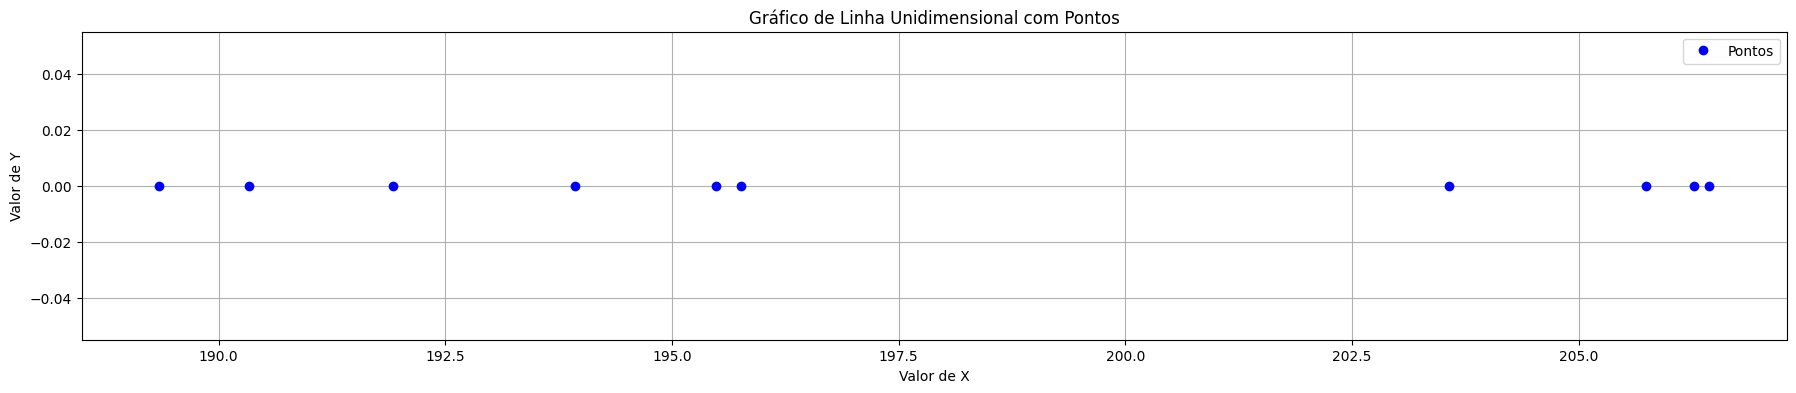

In [400]:
plot(wolfs)

In [401]:
for i in range(NUM_ITERATIONS):
    print(f"Iteration {i+1}")
    wolfs = determine_leaders(wolfs)
    update_position(
        wolfs,
        i,
        cars_state,
        travels,
        cars,
        charge_times,
        available_intervals,
        generated_power,
        products_demand,
        energy_cost,
    )

Iteration 1


KeyError: 'max_capacity'

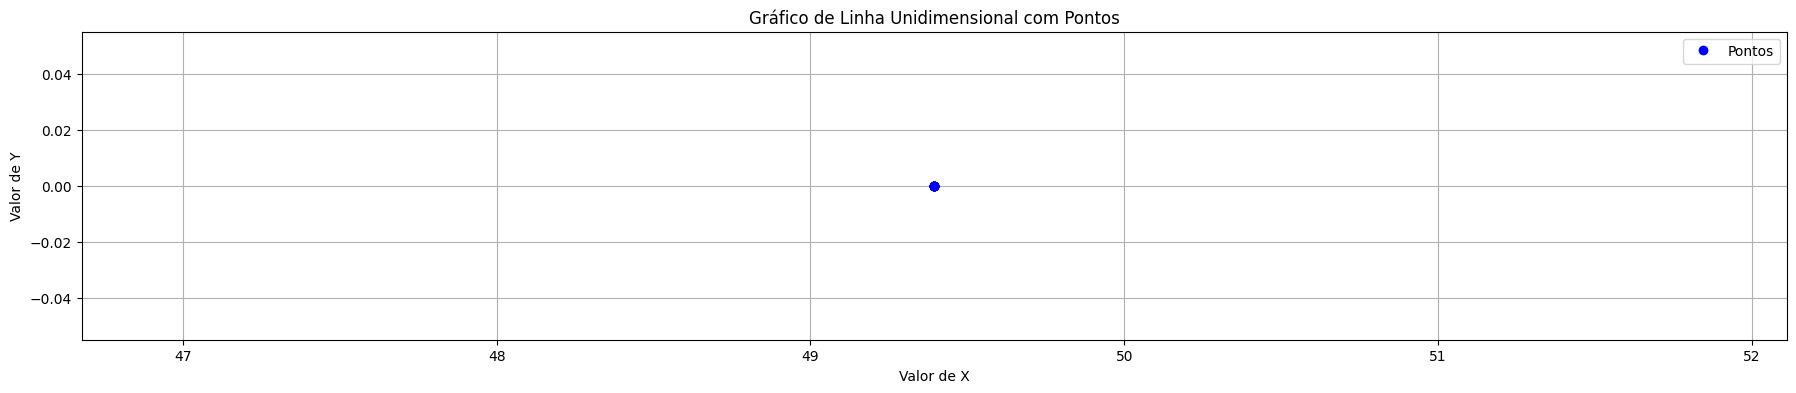

In [ ]:
plot(wolfs)